# ImageNet PaliGemma SAE Training

### Import libraries and define SAE class

In [1]:
# === Standard Library ===
import os
import gc
import copy
from threading import Thread
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

# === Third-Party Libraries ===
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import requests
import wandb
import multiprocessing

# === PyTorch ===
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Subset, Dataset
from torch.cuda.amp import autocast
import torch

# === Transformers & Datasets ===
from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    PaliGemmaForConditionalGeneration,
)
from datasets import load_dataset

# === TorchVision ===
from torchvision.utils import make_grid

# === TensorFlow (if needed) ===
import tensorflow as tf

DIM_IN = 2048
DIM_HIDDEN = 4096

# === Custom Dataset ===
class PromptImageDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=DIM_IN, d_hidden=DIM_HIDDEN):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

dtype = torch.float16
device_num = 4
if torch.cuda.is_available():
    torch.cuda.set_device(device_num)
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    dtype = torch.bfloat16

device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


2025-05-04 01:41:19.407329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 01:41:19.492794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2025-05-04 01:41:21.152995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Using device: cuda:4


### Load dataset and model (takes 3.5 minutes for 10k images)

In [2]:
# === Config ===
MODEL_ID = "google/paligemma-3b-mix-224"
TRAINING_DATASET = "imagenet-1k"
TRAINING_DATASET_SIZE = 10000
BATCH_SIZE = 64
NUM_WORKERS = 8
NUM_GPUS = 1
LAYER_INDEX = 23

In [3]:
# === Load model processor ===
processor = AutoProcessor.from_pretrained(MODEL_ID, use_fast=True)

# === Load + preprocess streaming dataset ===
streamed = load_dataset(TRAINING_DATASET, split="train", streaming=True)
dataset_iter = iter(streamed.take(TRAINING_DATASET_SIZE))
preprocessed_data = [{"image": ex["image"].convert("RGB"), "prompt": "<image> caption"} for ex in dataset_iter]

dataset = PromptImageDataset(preprocessed_data)

# === Collate function ===
def collate_fn(batch):
    images = [item["image"] for item in batch]
    prompts = [item["prompt"] for item in batch]
    return {"images": images, "prompts": prompts}

# === Split dataset across GPUs ===
chunks = torch.chunk(torch.arange(len(dataset)), NUM_GPUS)
subsets = [Subset(dataset, chunk.tolist()) for chunk in chunks]

# === Inference loop per GPU ===
all_activations = []
token_counts = []

for i in range(NUM_GPUS):
    device = f"cuda:{device_num + i}"
    print(f"Running inference on {device}...")

    model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device).eval()

    # Register hook
    vision_acts = {}
    def vision_hook(module, input, output):
        vision_acts["activation"] = output
    hook_handle = model.vision_tower.vision_model.encoder.layers[LAYER_INDEX].register_forward_hook(vision_hook)

    dataloader = DataLoader(subsets[i], batch_size=BATCH_SIZE, collate_fn=collate_fn,
                            num_workers=NUM_WORKERS, pin_memory=True)

    for batch in tqdm(dataloader, desc=f"Inference on {device}"):
        try:
            model_inputs = processor(
                text=batch["prompts"],
                images=batch["images"],
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=dtype):
                _ = model(**model_inputs)

            act = vision_acts.get("activation")
            if isinstance(act, tuple):
                act = act[0]

            all_activations.append(act.cpu().float())
            token_counts.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"[Error] Skipping batch: {e}")
            continue

    hook_handle.remove()
    del model, dataloader, vision_acts
    gc.collect()
    torch.cuda.empty_cache()

# === Final activation tensor ===
if not all_activations:
    raise ValueError("❌ No activations collected!")

all_activations = torch.cat(all_activations, dim=0)
print("✅ Collected activations:", all_activations.shape)
print("✅ Total tokens recorded:", sum(token_counts))

Running inference on cuda:4...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Inference on cuda:4:   0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipykernel_229238/3374189893.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=dtype):


✅ Collected activations: torch.Size([10000, 256, 1152])
✅ Total tokens recorded: 2560000


### Save to disk

In [ ]:
# Convert to half precision before saving (cuts size in half)
torch.save(all_activations, "all_activations.pt")
all_activations_fp16 = all_activations.half()
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(token_counts, "image_to_token_counts.pt")

### Train SAE

In [6]:
# === Hyperparameters ===
hidden_multiplier = 16
learning_rate = 5e-4
sparsity_weight = 3e-2
n_epochs = 15
batch_size = 256

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": hidden_multiplier,
    "learning_rate": learning_rate,
    "sparsity_weight": sparsity_weight,
    "n_epochs": n_epochs,
    "batch_size": batch_size,
})

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to(device) 
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

wandb: Currently logged in as: htsai (htsai2025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 5: Loss 0.272389
Epoch 10: Loss 0.074171
Epoch 15: Loss 0.040941
Finished training Sparse Autoencoder!
Saved SAE to checkpoints/sae_2025-05-04_01-55-14.pth


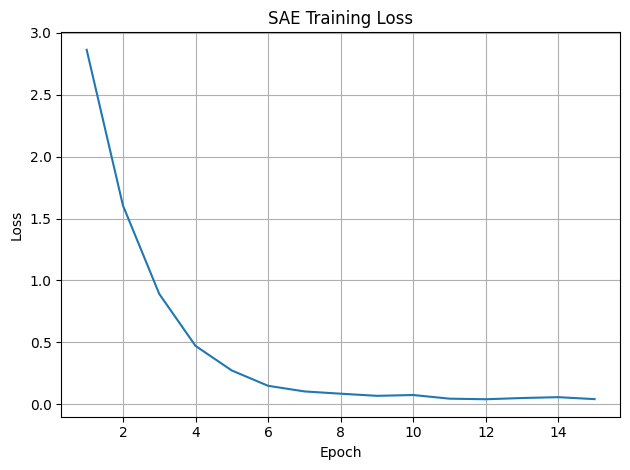

<Figure size 640x480 with 0 Axes>

In [7]:
epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch, in train_loader:
        batch = batch.to(device, non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    # Log to wandb every epoch
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
wandb.log({"loss_curve": wandb.Image(plt)})

### Load previously trained model

In [8]:
# Need to change model path to your own local folder and .pth filename
model_path = "/home/henrytsai/henry/roboterp/checkpoints/sae_2025-05-04_01-34-29.pth"

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations_fp16.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

# Define the model
sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden)
state_dict = torch.load(model_path, map_location=device)["state_dict"]

# If saved with DataParallel, strip 'module.' prefix
from collections import OrderedDict
if any(k.startswith("module.") for k in state_dict):
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    state_dict = new_state_dict

# Apply weights
sae.load_state_dict(state_dict)
sae = sae.to(device)
sae.eval()

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

### Visualize features (takes 3 minutes)

In [ ]:
# ==== CONFIG ====
top_k = 5
n_features_to_plot = 5
batch_size = 4096  # tune based on your GPU memory
num_workers = 16    # number of parallel CPU threads


# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=sae_device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=sae_device, dtype=sae_dtype)
        sparse = sae.activation(sae.encoder(batch))
        running_sum += sparse.sum(dim=0)
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)

# ==== TOKEN-TO-IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)

assert len(image_indices_per_token) == sparse_features.shape[0], \
    f"Mismatch: {len(image_indices_per_token)} vs {sparse_features.shape[0]}"

image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== PARALLEL IMAGE LOADING ====
def load_rgb(idx):
    img_idx = int(image_indices_per_token[idx])
    image = dataset[img_idx]["image"].convert("RGB")
    return np.array(image)

IndentationError: unexpected indent (2635438507.py, line 75)

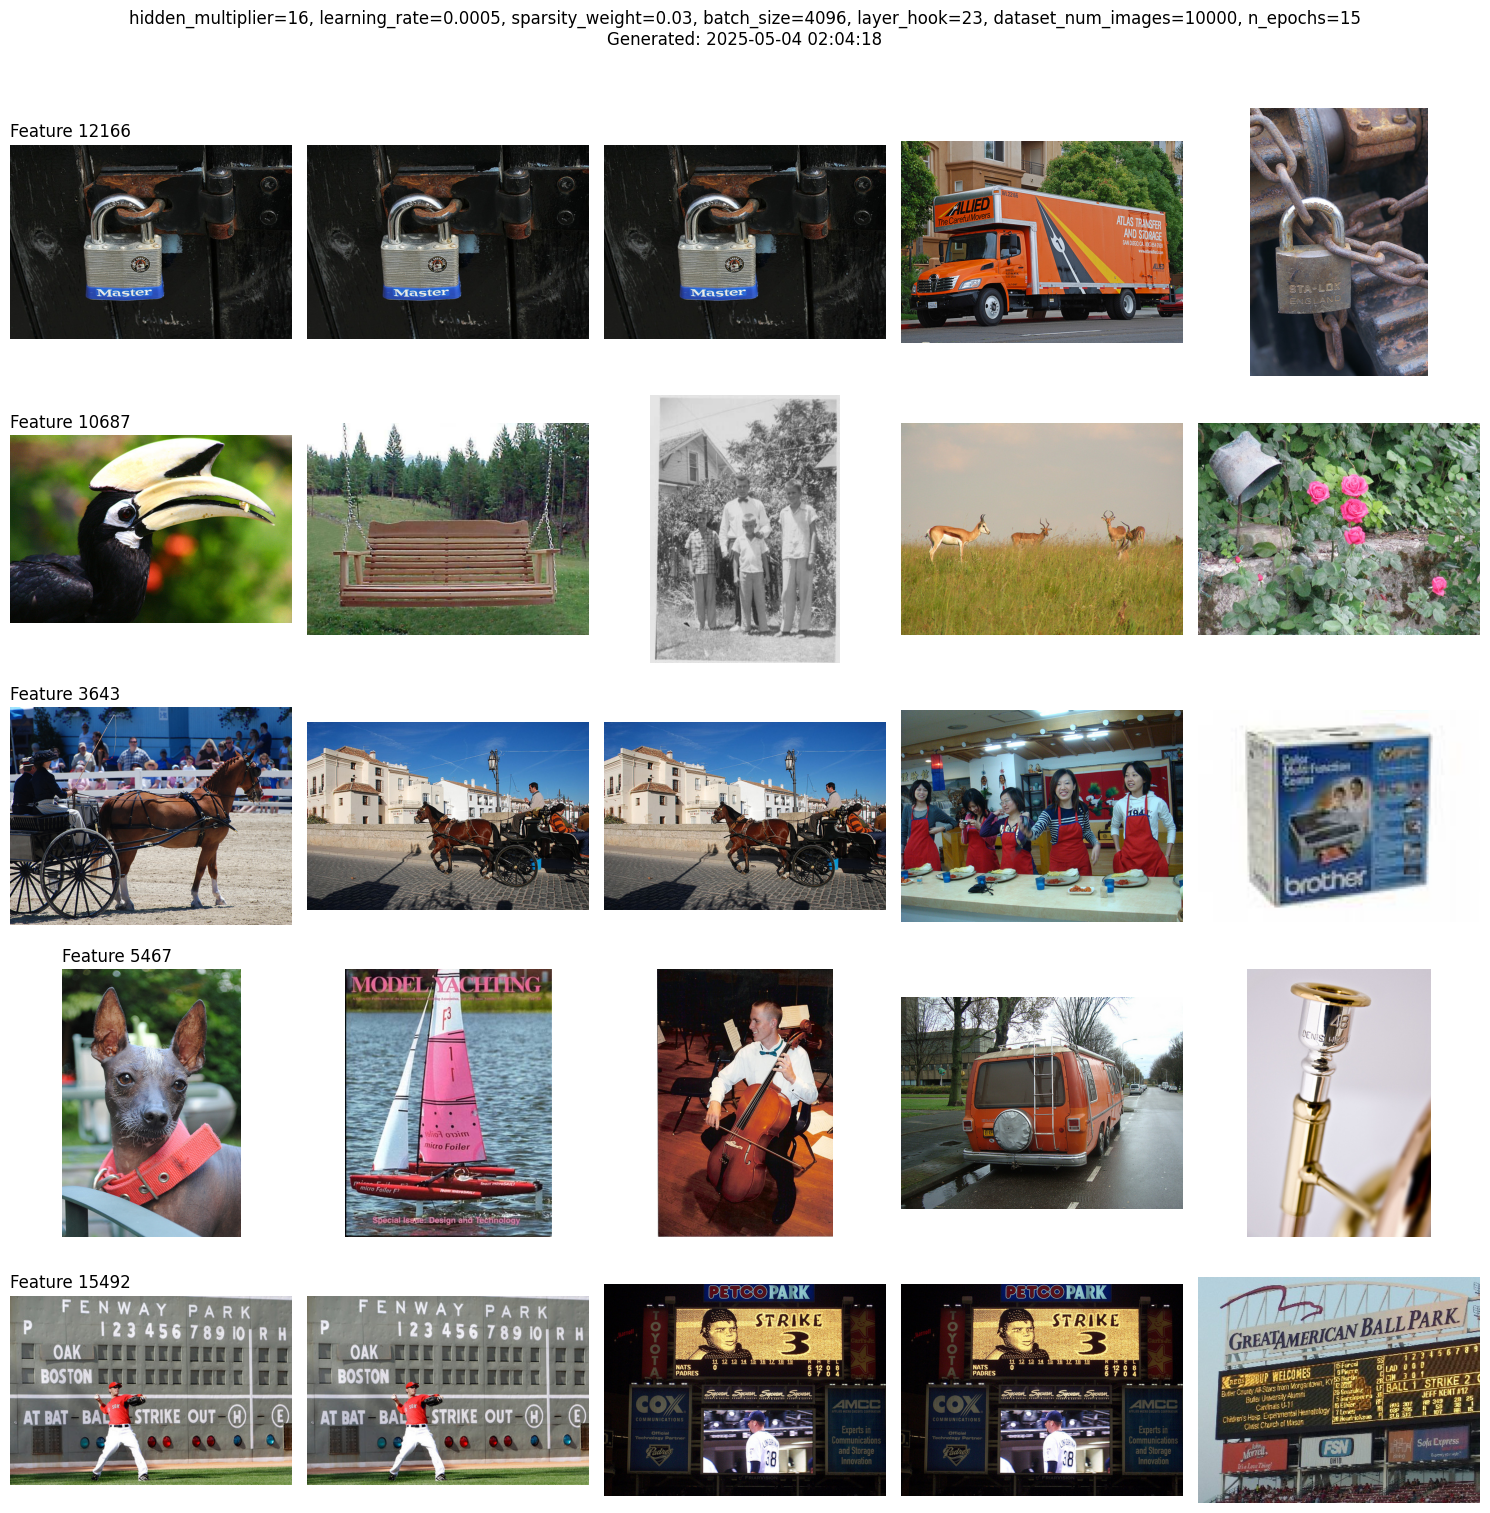

In [ ]:
# === Config ===
rows = len(top_features)
cols = top_k
figsize = (3 * cols, 3 * rows)

# === Create figure ===
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = np.array(axes).reshape(rows, cols)  # handles case when rows=1 or cols=1

# === Add top bar with metadata ===
info_text = (
    f"hidden_multiplier={hidden_multiplier}, "
    f"learning_rate={learning_rate}, "
    f"sparsity_weight={sparsity_weight}, "
    f"batch_size={batch_size}, "
    f"layer_hook={LAYER_INDEX}, "
    f"dataset_num_images={TRAINING_DATASET_SIZE}, "
    f"n_epochs={n_epochs},"
    f"model_path={model_path}\n",
    f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
)
fig.suptitle(info_text, fontsize=12, y=1.02)

# === Display each row of top-k activating images for each feature ===
for row_idx, feature_idx in enumerate(top_features):
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load images
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    for col_idx, (img, ax) in enumerate(zip(images, axes[row_idx])):
        ax.imshow(img)
        ax.axis("off")
        if col_idx == 0:
            ax.set_title(f"Feature {feature_idx}", fontsize=12, loc="left")

# === Final layout ===
plt.subplots_adjust(top=0.9, hspace=0.3)
plt.tight_layout()
plt.show()


### Sparsity analysis

In [22]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from datetime import datetime
import wandb

# === Setup SAE ===
sae = sae.to(device)
sae.eval()

# === Initialize streaming stats ===
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
running_count = 0

# For global stats
moment_1 = 0.0
moment_2 = 0.0
moment_3 = 0.0
moment_4 = 0.0
global_count = 0

with torch.no_grad():
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # [N, d_hidden]
        abs_z = torch.abs(z)
        
        # Feature usage
        running_sum += abs_z.sum(dim=0)
        running_count += z.size(0)

        # Flatten all values for global stats
        z_flat = abs_z.view(-1).cpu().numpy()
        N = len(z_flat)
        global_count += N

        moment_1 += np.sum(z_flat)
        moment_2 += np.sum(z_flat ** 2)
        moment_3 += np.sum(z_flat ** 3)
        moment_4 += np.sum(z_flat ** 4)

# === Compute feature-wise usage ===
feature_usage = running_sum / running_count  # shape: [d_hidden]

# === Compute global statistics ===
mean_val = moment_1 / global_count
var_val = moment_2 / global_count - mean_val ** 2
std_val = np.sqrt(var_val)
skewness = (moment_3 / global_count - 3 * mean_val * var_val - mean_val ** 3) / (std_val ** 3)
kurt = (moment_4 / global_count - 4 * mean_val * moment_3 / global_count + 6 * mean_val**2 * var_val + 3 * mean_val**4) / (std_val ** 4) - 3

print("📊 Latent Feature Activation (|z|) Statistics (streamed):")
print(f"  Mean     : {mean_val:.6f}")
print(f"  Std Dev  : {std_val:.6f}")
print(f"  Skewness : {skewness:.6f}")
print(f"  Kurtosis : {kurt:.6f}")
print(f"  Count    : {global_count}")

# === Plot feature usage ===
plt.figure(figsize=(10, 5))
plt.hist(feature_usage.cpu().numpy(), bins=100, alpha=0.85)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)

# === Annotate ===
info_text = (
    f"hidden_multiplier={hidden_multiplier}, "
    f"learning_rate={learning_rate}, "
    f"sparsity_weight={sparsity_weight}, "
    f"batch_size={batch_size}, "
    f"layer_hook={LAYER_INDEX}, "
    f"dataset_num_images={TRAINING_DATASET_SIZE}, "
    f"n_epochs={n_epochs}, "
    f"model_path={model_path}\n"
    f"Mean={mean_val:.4f}, Std={std_val:.4f}, "
    f"Skew={skewness:.2f}, Kurtosis={kurt:.2f} | "
    f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
)
plt.gcf().text(0.5, -0.15, info_text, ha="center", fontsize=10)

# === Finalize + log ===
plt.tight_layout()
plt.show()

wandb.log({
    "feature_usage_histogram": wandb.Image(plt),
    "z_mean": mean_val,
    "z_std": std_val,
    "z_skewness": skewness,
    "z_kurtosis": kurt,
})


Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7a06cb0aa900>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7a07cb361b00, raw_cell="from torch.utils.data import DataLoader
import tor.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a223138327633227d/home/henrytsai/henry/roboterp/safaa_visualizer.ipynb#X22sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

ModuleNotFoundError: No module named 'scipy'

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7a06cb0aa900>> (for post_run_cell), with arguments args (<ExecutionResult object at 7a07cb362900, execution_count=22 error_before_exec=None error_in_exec=No module named 'scipy' info=<ExecutionInfo object at 7a07cb361b00, raw_cell="from torch.utils.data import DataLoader
import tor.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a223138327633227d/home/henrytsai/henry/roboterp/safaa_visualizer.ipynb#X22sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

### Clean up memory

In [11]:
# del [insert variable]
del d_hidden
torch.cuda.empty_cache()
gc.collect()

41101